## 📊 A/B Testing: Facebook vs AdWords Campaign Performance Analysis


### 🎯 Business Problem
As a marketing agency, our objective is to maximize ROI for clients’ advertising campaigns. 
We want to determine which platform Facebook Ads or Google AdWords generates more conversions and delivers better performance.


### Data Description

The dataset comprises a collection of data comparing the performance of two separate digital advertising campaigns conducted throughout the year 2019. Specifically, the dataset covers a Facebook Ads campaign and a Google AdWords campaign. For each day of the year 2019, there is a corresponding record in the dataset, resulting in a total of 365 observations.

The dataset includes multiple performance metrics for each advertising platform, providing insights into their effectiveness, efficiency, and cost performance over time. This structure allows for a direct comparison between the two platforms and makes the dataset well-suited for A/B testing and marketing performance analysis.

Key Features Included in the Dataset
- Date The date corresponding to each row of campaign data, ranging from January 1st, 2019 to December 31st, 2019.
- Ad Views The number of times an advertisement was displayed to users (impressions).
- Ad Clicks The total number of clicks received on the advertisement.
- Ad Conversions The number of successful conversions generated from the advertisement, such as purchases or sign-ups.
- Cost per Ad The total cost incurred for running the advertising campaign on the respective platform.
- Click-Through Rate (CTR) The ratio of ad clicks to ad views, indicating how effectively the advertisement generates user interest.
- Conversion Rate The ratio of conversions to clicks, reflecting how efficiently the advertisement drives desired user actions.
- Cost per Click (CPC) The average cost incurred for each click on the advertisement.

In [15]:
#importing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import coint

import warnings
warnings.filterwarnings('ignore')

In [16]:
#loding dataset
df = pd.read_csv('../data/marketing_campaign_data.csv')

#data overview
df.head(2)

,Date,Facebook Ad Campaign,Facebook Ad Views,Facebook Ad Clicks,Facebook Ad Conversions,Cost per Facebook Ad,Facebook Click-Through Rate (Clicks / View),Facebook Conversion Rate (Conversions / Clicks),Facebook Cost per Click (Ad Cost / Clicks),AdWords Ad Campaign,AdWords Ad Views,AdWords Ad Clicks,AdWords Ad Conversions,Cost per AdWords Ad,AdWords Click-Through Rate (Clicks / View),AdWords Conversion Rate (Conversions / Clicks),AdWords Cost per Click (Ad Cost / Clicks)
0,1/1/2019,FB_Jan19,1860,24,15,$121,1.29%,62.50%,$5.04,AW_Jan19,4638,58,26,$144,1.25%,44.83%,$2.48
1,1/2/2019,FB_Jan19,2482,33,25,$149,1.33%,75.76%,$4.52,AW_Jan19,5919,63,6,$122,1.06%,9.52%,$1.94


In [17]:
#rows and columns count of the data
df.shape

(365, 17)

In [18]:
#datatype of the columns
df.dtypes

Date                                               object
Facebook Ad Campaign                               object
Facebook Ad Views                                   int64
Facebook Ad Clicks                                  int64
Facebook Ad Conversions                             int64
Cost per Facebook Ad                               object
Facebook Click-Through Rate (Clicks / View)        object
Facebook Conversion Rate (Conversions / Clicks)    object
Facebook Cost per Click (Ad Cost / Clicks)         object
AdWords Ad Campaign                                object
AdWords Ad Views                                    int64
AdWords Ad Clicks                                   int64
AdWords Ad Conversions                              int64
Cost per AdWords Ad                                object
AdWords Click-Through Rate (Clicks / View)         object
AdWords Conversion Rate (Conversions / Clicks)     object
AdWords Cost per Click (Ad Cost / Clicks)          object
dtype: object

In [19]:
#converting date to datetime
df['Date'] = pd.to_datetime(df['Date'])

In [20]:
#descriptive stats of the campaign
df.describe()

,Date,Facebook Ad Views,Facebook Ad Clicks,Facebook Ad Conversions,AdWords Ad Views,AdWords Ad Clicks,AdWords Ad Conversions
count,365,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,2019-07-02 00:00:00,2469.632877,29.904110,16.652055,4541.994521,60.295890,31.821918
min,2019-01-01 00:00:00,1021.000000,10.000000,5.000000,3016.000000,40.000000,4.000000
25%,2019-04-02 00:00:00,1804.000000,21.000000,9.000000,3870.000000,49.000000,17.000000
50%,2019-07-02 00:00:00,2492.000000,30.000000,15.000000,4521.000000,61.000000,30.000000
75%,2019-10-01 00:00:00,3132.000000,39.000000,21.000000,5199.000000,71.000000,44.000000
max,2019-12-31 00:00:00,3987.000000,49.000000,45.000000,5994.000000,79.000000,77.000000
std,NaN,825.527455,11.279618,9.210125,826.168620,11.763471,18.032284


### 📈 Distribution & Frequency Analysis


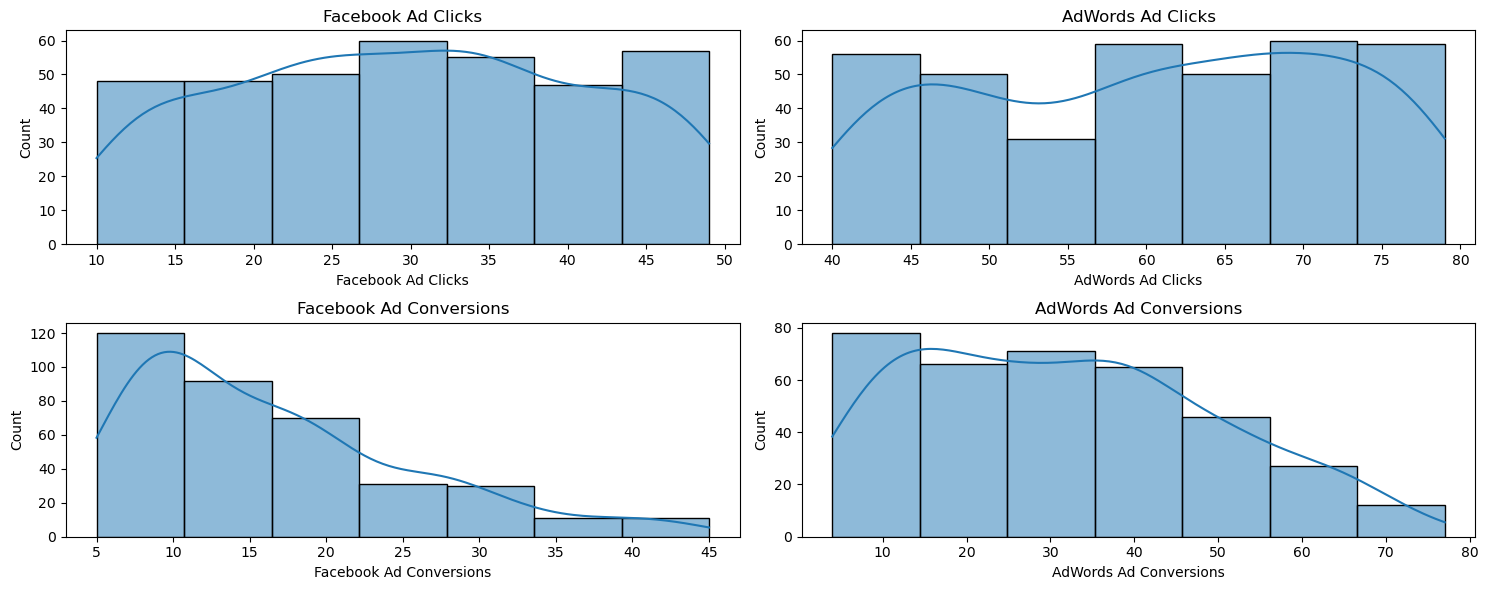

In [21]:
plt.figure(figsize=(15,6))

plt.subplot(2,2,1)
sns.histplot(df['Facebook Ad Clicks'], bins=7, kde=True)
plt.title('Facebook Ad Clicks')

plt.subplot(2,2,2)
sns.histplot(df['AdWords Ad Clicks'], bins=7, kde=True)
plt.title('AdWords Ad Clicks')

plt.subplot(2,2,3)
sns.histplot(df['Facebook Ad Conversions'], bins=7, kde=True)
plt.title('Facebook Ad Conversions')

plt.subplot(2,2,4)
sns.histplot(df['AdWords Ad Conversions'], bins=7, kde=True)
plt.title('AdWords Ad Conversions')

plt.tight_layout()
plt.show()


- The distribution analysis shows that AdWords campaigns generally achieve higher daily clicks and conversions compared to Facebook. While both platforms exhibit relatively stable click distributions, Facebook conversions appear more right-skewed, indicating greater variability and occasional high-conversion days. These observations suggest that AdWords may be more effective, though statistical testing is required to confirm significance.


##### How frequently do we observe days with high number of conversions compare to days with low number of conversions?

In [22]:
#creating function to calculater the category of conversions
def create_conversion_category(conversion_col):
    category = []
    for conversion in df[conversion_col]:
        if conversion < 6:
            category.append('less than 6')
        elif 6 <= conversion < 10:
            category.append('6 - 10')
        elif 11 <= conversion < 15:
            category.append('11 - 15')
        else:
            category.append('more than 15')
    return category

#applying function of different campaigns conversions
df['Facebook Conversion Category'] = create_conversion_category('Facebook Ad Conversions')
df['AdWords Conversion Category'] = create_conversion_category('AdWords Ad Conversions')
df[['Facebook Ad Conversions','Facebook Conversion Category','AdWords Ad Conversions','AdWords Conversion Category']].head()

,Facebook Ad Conversions,Facebook Conversion Category,AdWords Ad Conversions,AdWords Conversion Category
0,15,more than 15,26,more than 15
1,25,more than 15,6,6 - 10
2,16,more than 15,24,more than 15
3,21,more than 15,63,more than 15
4,9,6 - 10,12,11 - 15


In [23]:
#creating dataframes for facebook conversion categories
facebook = pd.DataFrame(df['Facebook Conversion Category'].value_counts()).reset_index().rename(columns={'Facebook Conversion Category':'Category'})

#creating dataframe for adwords conversion category dataframe
adwords = pd.DataFrame(df['AdWords Conversion Category'].value_counts()).reset_index().rename(columns={'AdWords Conversion Category':'Category'})

#merging both dataframes
category_df = pd.merge(facebook, adwords, on='Category', how='outer').fillna(0)
category_df

,Category,count_x,count_y
0,11 - 15,60,33
1,6 - 10,79,25
2,less than 6,14,16
3,more than 15,212,291


In [24]:
#reordering the category dataframe
category_df = category_df.iloc[[2,1,0,3]]
category_df

,Category,count_x,count_y
2,less than 6,14,16
1,6 - 10,79,25
0,11 - 15,60,33
3,more than 15,212,291


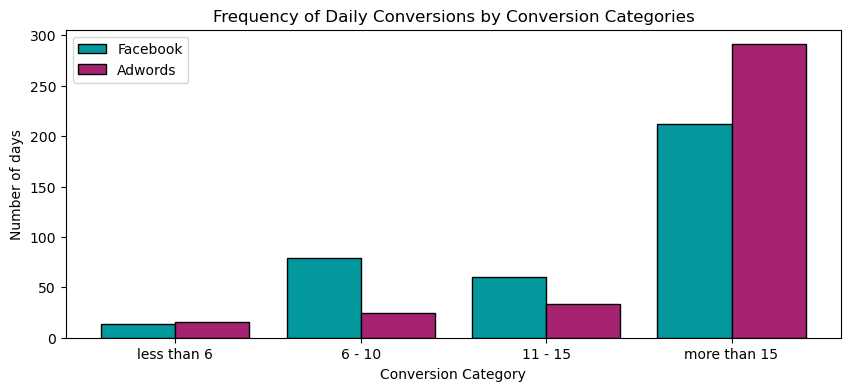

In [25]:
X_axis = np.arange(len(category_df))

plt.figure(figsize=(10,4))
plt.bar(X_axis - 0.2, category_df['count_x'], 0.4, label='Facebook', color='#03989E', linewidth=1, edgecolor='k')
plt.bar(X_axis + 0.2, category_df['count_y'], 0.4, label='Adwords', color='#A62372', linewidth=1, edgecolor='k')

plt.xticks(X_axis, category_df['Category'])
plt.xlabel("Conversion Category")
plt.ylabel("Number of days")
plt.title("Frequency of Daily Conversions by Conversion Categories")
plt.legend()
plt.show()

- The frequency distribution shows that Facebook records more days in the low to mid conversion categories (6–10 and 11–15), while AdWords dominates the high conversion category (more than 15). This indicates that although Facebook delivers consistent moderate conversions, AdWords is more effective at generating a higher number of high-performing conversion days.


### 🔗 Correlation Analysis (Clicks vs Conversions)


#### Do more clicks on the ad really lead to more sales?

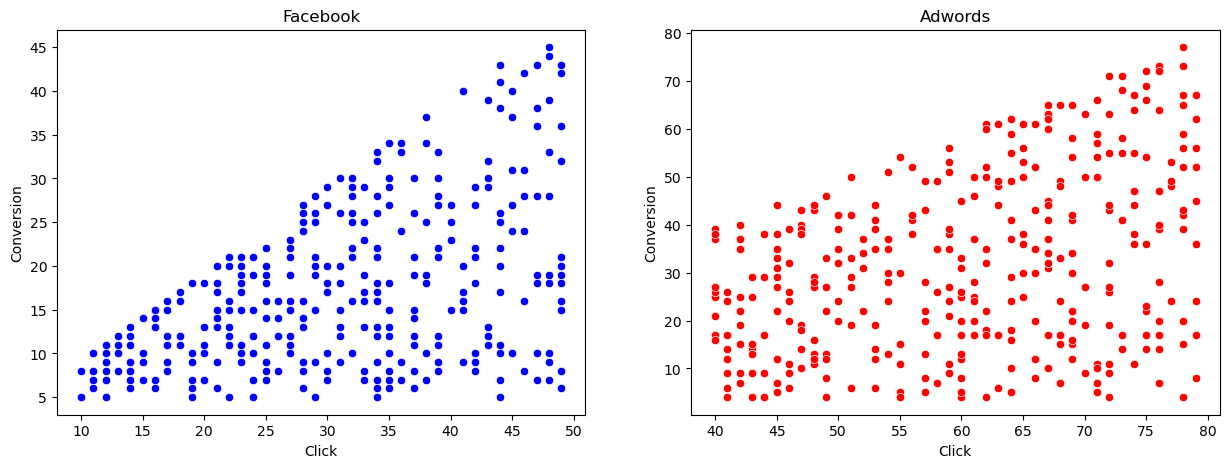

In [26]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title('Facebook')
sns.scatterplot(x=df['Facebook Ad Clicks'], y=df['Facebook Ad Conversions'], color='blue')
plt.xlabel('Click')
plt.ylabel('Conversion')

plt.subplot(1,2,2)
plt.title('Adwords')
sns.scatterplot(x=df['AdWords Ad Clicks'], y=df['AdWords Ad Conversions'], color='red')
plt.xlabel('Click')
plt.ylabel('Conversion')
plt.show()

In [27]:
#calculating correlation coefficient
facebook_corr = df[['Facebook Ad Conversions', 'Facebook Ad Clicks']].corr()
adwords_corr = df[['AdWords Ad Conversions', 'AdWords Ad Clicks']].corr()

print('Corelation Coefficient:')
print("Facebook", round(facebook_corr.values[0,1],2))
print("Adwords", round(adwords_corr.values[0,1],2))

Corelation Coefficient:
Facebook 0.53
Adwords 0.37


- Facebook shows a moderate positive correlation (0.53) between clicks and conversions, while AdWords shows a weaker relationship (0.37). This suggests that Facebook traffic is more likely to convert after clicking, indicating higher-quality user engagement. In contrast, AdWords generates clicks that are less consistently converted into actions.


#### Hypothesis Testing
Null Hypothesis (H₀): There is no significant difference in the mean number of conversions between Facebook and AdWords campaigns.
Alternative Hypothesis (H₁): Facebook advertising results in a greater mean number of conversions compared to AdWords.

μFacebook​>μAdWords​

In [28]:
# groups
fb = df['Facebook Ad Conversions']
ad = df['AdWords Ad Conversions']

# means
fb_mean = fb.mean()
ad_mean = ad.mean()

print(f"Facebook mean conversions : {fb_mean:.2f}")
print(f"AdWords mean conversions  : {ad_mean:.2f}")

# Welch’s t-test (recommended)
t_stat, p_value = st.ttest_ind(fb, ad, equal_var=False)

print(f"\nt-statistic : {t_stat:.3f}")
print(f"p-value     : {p_value:.6f}")

alpha = 0.05

if p_value < alpha:
    print("\n✅ Reject H0 → Significant difference exists")
else:
    print("\n❌ Fail to reject H0 → No significant difference")

Facebook mean conversions : 16.65
AdWords mean conversions  : 31.82

t-statistic : -14.313
p-value     : 0.000000

✅ Reject H0 → Significant difference exists


- AdWords significantly outperforms Facebook in generating conversions.
- AdWords significantly outperforms Facebook in conversions therefore budget allocation should prioritize AdWords to maximize ROI.